In [1]:
!pip install -q clu

In [2]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-05-20 18:46:27--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt.3'

input.txt.3         100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2024-05-20 18:46:27 (28.0 MB/s) - 'input.txt.3' saved [1115394/1115394]



In [3]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

In [4]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
data = jnp.array(encode(text), dtype=jnp.int32)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

(1115394,) int32
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1 39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39
 58 46 43 56  1 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47
 57 46 12  0  0 13 50 50 10  0 30 43 57 53 50 60 43 42  8  1 56 43 57 53
 50 60 43 42  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 18 47
 56 57 58  6  1 63 53 59  1 49 52 53 61  1 15 39 47 59 57  1 25 39 56 41
 47 59 57  1 47 57  1 41 46 47 43 44  1 43 52 43 51 63  1 58 53  1 58 46
 43  1 54 43 53 54 50 43  8  0  0 13 50 50 10  0 35 43  1 49 52 53 61  5
 58  6  1 61 43  1 49 52 53 61  5 58  8  0  0 18 47 56 57 58  1 15 47 58
 47 64 43 52 10  0 24 43 58  1 59 57  1 49 47 50 50  1 46 47 51  6  1 39
 52 42  1 61 43  5 50 50  1 46 39 

In [8]:
train_test_split = 0.9
n = int(train_test_split*len(data))
train_data = data[:n]
test_data = data[n:]

In [9]:
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [10]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [11]:
batch_size = 128 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
max_iters = 3000
eval_interval = 1000
learning_rate = 5e-4
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 256
expans = 2
n_heads = 1
channel_size = n_embd // n_heads
n_layers = 2
dropout = 0.2
conv_k_size = 3
n_latent_dim = 16

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + 1, (block_size,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

# print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context} the target: {target}")

inputs:
(128, 64)
[[ 1 63 53 ... 40 63  1]
 [43  1 52 ... 46 39 42]
 [63  1 45 ... 50  1 61]
 ...
 [46 47 41 ... 58 43  1]
 [ 1 61 43 ... 53 59  1]
 [49  1 58 ... 53 61  1]]
targets:
(128, 64)
[[63 53 59 ... 63  1 58]
 [ 1 52 43 ... 39 42  1]
 [ 1 45 53 ...  1 61 43]
 ...
 [47 41 46 ... 43  1 47]
 [61 43  5 ... 59  1 42]
 [ 1 58 46 ... 61  1 52]]


# Mamba Block
Dense --> Conv1D --> Silu --> SSM --> Silu -->

In [12]:
class Mamba(nn.Module):

    def setup(self):
        emb_features = n_embd * expans
        self.in_proj1 = nn.Dense(features=emb_features)
        self.in_proj2 = nn.Dense(features=emb_features)

        # Adjusted for Flax. Flax does not have nn.Conv1d, so you might need to reshape or use a different approach
        self.conv1d = nn.Conv(features=emb_features,
                              kernel_size=conv_k_size,
                              padding=1,
                              )

        self.A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, emb_features, 1))
        self.B = 0.1*self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, block_size))
        self.C = self.param('C', jax.random.normal, (1, n_latent_dim, 1, block_size))
#         self.D = self.param('D', jax.random.normal, (1, self.args.d_state, self.args.d_model, 1))
        self.delta = self.param('delta', jax.random.normal, (1, 1,emb_features, block_size))

        self.out_proj = nn.Dense(n_embd // n_heads)
        
        self.hidden_state = self.variable('other_variables','hiddent_state', 
                                          nn.zeros, jax.random.key(1), 
                                          (1,n_latent_dim, emb_features))
        self.rms_norm = nn.RMSNorm()

    def __call__(self, embeds):
        
        x = self.in_proj1(embeds)
        x = self.conv1d(x)
        x = jax.nn.silu(x)
        x = x.reshape((x.shape[0],1,x.shape[2],x.shape[1]))
        x = self.ssm(x)[1]
        x = x.reshape((x.shape[0],x.shape[3],x.shape[2]))
        x = x*jax.nn.silu(self.in_proj2(embeds))

        x = self.out_proj(x)

        x = self.rms_norm(x)

        return x
    def discretize(self):
        da = self.delta * self.A
        a_ = jnp.exp(da)
        b_ = self.B * self.delta
        return a_, b_

    def ssm(self, x):
        y = []
#         h = 0
        a_, b_ = self.discretize()
        for k in range(x.shape[-1]):
#             print('#########: ',self.hidden_state.value)
            self.hidden_state.value = a_[..., k] * self.hidden_state.value + b_[..., k] * x[..., k]
            y.append((self.C[..., k] * self.hidden_state.value).sum(1, keepdims=True))
        return self.hidden_state.value, jnp.stack(y, -1)

In [13]:
# class MultiHeadMamba(nn.Module):
#     def setup(self):
#         self.layernorm
#         self.heads = [Mamba() for _ in range(n_heads)]
#         self.rms_norm = nn.RMSNorm()

#     def __call__(self, x):
#         out = jnp.concatenate([h(x) for h in self.heads], axis=-1)
#         x = self.rms_norm(out)
#         return x

In [14]:
class FeedForward(nn.Module):
    def setup(self):
        self.ffn = nn.Sequential([
            nn.Dense(4 * n_embd),
            nn.relu,
            nn.Dense(n_embd)]
        )
    def __call__(self, x):
        return self.ffn(x)

In [15]:
class MambaBlock(nn.Module):
    def setup(self):
        self.mamba_block = Mamba()
        self.ln1 = nn.RMSNorm()
        self.ffn = FeedForward()
        self.ln2 = nn.LayerNorm()

    def __call__(self, x):
        x = x + self.mamba_block(self.ln2(x))
        x = x + self.ffn(self.ln1(x))
        return x


In [16]:
class MambaModel(nn.Module):

    def setup(self):
        self.tok_embeddings = nn.Embed(vocab_size, n_embd)
        self.pos_embeddings = nn.Embed(block_size, n_embd)
        self.ln = nn.LayerNorm()
        self.mamba_layers = [MambaBlock() for _ in range(n_layers)]
        self.preds_out = nn.Dense(vocab_size)

    def __call__(self, x, training: bool):
        x = self.tok_embeddings(x) + self.pos_embeddings(jnp.arange(block_size))
#         x = self.ln(x)
        for layer in self.mamba_layers:
            x = layer(x)
            
        return self.preds_out(x)

    @jax.jit
    def generate(self, idx, max_new_tokens, params):
    # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self.apply(params, idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            ##probs = tf.keras.activations.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = jax.random.categorical(jax.random.PRNGKey(52), logits) # (B, 1)
            # append sampled index to the running sequence
            idx = jax.numpy.expand_dims(jnp.concatenate([idx[0], idx_next], axis=0), 0) # (B, T+1)
    #         print(idx_next)
    #         print(idx)

        return idx

In [17]:
# model = Mamba()
# params = model.init({'params': key}, jnp.ones((1,64,256)))
# print(model.tabulate(jax.random.key(0), jnp.ones((1,64,256)),
#                    compute_flops=True, compute_vjp_flops=True))
# # xs = model.apply(params, xb)
# # xb.shape, xs.shape

In [18]:
# test_model = Mamba()
# test_params = test_model.init(jax.random.key(42), xb)
# n_params = sum(p.size for p in jax.tree_util.tree_leaves(test_params))
# print(f"Total number of parameters: {n_params:_}")
# # print(fin_model.tabulate(jax.random.key(42), xb,
# #                    compute_flops=True, compute_vjp_flops=True))
# xf = test_model.apply(test_params, xb)
# xb.shape, xf.shape

In [19]:
class NanoLM(nn.Module):
    """NanoLM model."""
    vocab_size: int = 65
    num_layers: int = 6
    num_heads: int = 8
    head_size: int = 32
    dropout_rate: float = 0.2
    embed_size: int = 256
    block_size: int = 64

    @nn.compact
    def __call__(self, x, training: bool):

        x = nn.Embed(self.vocab_size, self.embed_size)(x) + nn.Embed(
            self.block_size, self.embed_size
        )(jnp.arange(self.block_size))
        
        for _ in range(self.num_layers):
            x_norm = nn.LayerNorm()(x)
            
#             x = x + nn.MultiHeadDotProductAttention(
#               num_heads=self.num_heads,
#               qkv_features=self.head_size,
#               out_features=self.head_size * self.num_heads,
#               dropout_rate=self.dropout_rate,
#             )(
#               x_norm,
#               x_norm,
#               mask=jnp.tril(jnp.ones((x.shape[-2], x.shape[-2]))),
#               deterministic=not training,
#             )

            x = x + Mamba()(x_norm)

            x = x + nn.Sequential([
              nn.Dense(4 * self.embed_size),
              nn.relu,
              nn.Dropout(self.dropout_rate, deterministic=not training),
              nn.Dense(self.embed_size),
            ])(nn.LayerNorm()(x))

        x = nn.LayerNorm()(x)
        return nn.Dense(self.vocab_size)(x)

In [20]:
key = jax.random.key(42)

# fin_model = MambaModel()
# fin_params = fin_model.init(key, xb, training=False)


fin_model = NanoLM(
    vocab_size=vocab_size,
    num_layers=n_layers,
    num_heads=8,
    head_size=32,
    dropout_rate=0.2,
    embed_size=n_embd,
    block_size=block_size,
)

fin_params = fin_model.init(
    {'params': key},
    jnp.ones((batch_size, block_size), dtype=jnp.int32),
    training=False
)

n_params = sum(p.size for p in jax.tree_util.tree_leaves(fin_params))
print(f"Total number of parameters: {n_params:_}")
# print(fin_model.tabulate(jax.random.key(42), xb,
#                    compute_flops=True, compute_vjp_flops=True))
xf = fin_model.apply(fin_params, xb, training=False, mutable=['other_variables'])[0]
xb.shape, xf.shape

Total number of parameters: 5_649_985


((128, 64), (128, 64, 65))

In [21]:
n_embd * expans

512

In [22]:
# token_gen = generate(jnp.zeros((1,1)).astype(jnp.int32), 100, fin_model, fin_params)
# print(token_gen)
# print(decode(token_gen[0].tolist()))

In [23]:
jax.random.categorical(jax.random.PRNGKey(5332), 1000.0*xf[1][-1][:])

Array(60, dtype=int32)

In [24]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [25]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, train_shape):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones(train_shape).astype(jnp.int32), 
                         training=False)['params'] # initialize parameters by passing a template image
    tx = optax.adamw(learning_rate)
    return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty(),
    )

In [26]:
@jax.jit
def train_step(state, inputs, targets):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, inputs, training=True, 
                                rngs={"dropout": key}, mutable=['other_variables'] )[0]
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=targets).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [27]:
@jax.jit
def compute_metrics(*, state, inputs, targets):
    logits = state.apply_fn({'params': state.params}, inputs, training=False, mutable=['other_variables'])[0]
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=targets).mean()
    metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=targets, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [28]:
num_epochs = 10
learning_rate = 0.005
init_rng = jax.random.key(0)

In [29]:
state = create_train_state(fin_model, init_rng, learning_rate, train_shape)
del init_rng  # Must not be used anymore.

In [30]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [31]:
SEED = 442
key = jax.random.PRNGKey(SEED)
for step in tqdm(range(max_iters)): # increase number of steps for good results...

      # sample a batch of data
    xb, yb = get_batch(key, train_data)
    state = train_step(state, xb, yb)
    state = compute_metrics(state=state, inputs=xb, targets=yb)

    key = (jax.random.split(key)[0])

    if step == 0 or (step+1) % 100 == 0: # one training epoch has passed
        for metric,value in state.metrics.compute().items(): # compute metrics
            metrics_history[f'train_{metric}'].append(value) # record metrics
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

        # Compute metrics on the test set after each training epoch
        test_state = state
        x_test, y_test = get_batch(key, test_data)
    #     for test_batch in test_ds.as_numpy_iterator():
        test_state = compute_metrics(state=test_state, inputs=x_test, targets=y_test)

        for metric,value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        print(f"train epoch: {(step+1)}, "
              f"loss: {metrics_history['train_loss'][-1]}, "
              f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {(step+1) }, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

  0%|          | 8/3000 [00:33<2:31:47,  3.04s/it] 

train epoch: 1, loss: 6.397836685180664, accuracy: 15.44189453125
test epoch: 1, loss: 6.522250175476074, accuracy: 15.1611328125


  4%|▎         | 107/3000 [00:40<02:54, 16.61it/s] 

train epoch: 100, loss: 3.088646411895752, accuracy: 20.218048095703125
test epoch: 100, loss: 2.16831374168396, accuracy: 37.2314453125


  7%|▋         | 207/3000 [00:46<02:48, 16.57it/s]

train epoch: 200, loss: 1.128042459487915, accuracy: 65.5540771484375
test epoch: 200, loss: 0.44078168272972107, accuracy: 87.36572265625


 10%|█         | 307/3000 [00:53<02:43, 16.52it/s]

train epoch: 300, loss: 0.2816229462623596, accuracy: 92.259521484375
test epoch: 300, loss: 0.1175495833158493, accuracy: 96.7529296875


 14%|█▎        | 407/3000 [01:00<02:36, 16.54it/s]

train epoch: 400, loss: 0.07786569744348526, accuracy: 97.989501953125
test epoch: 400, loss: 0.060078639537096024, accuracy: 98.64501953125


 17%|█▋        | 507/3000 [01:06<02:30, 16.56it/s]

train epoch: 500, loss: 0.06444916874170303, accuracy: 98.3067626953125
test epoch: 500, loss: 0.1227264553308487, accuracy: 96.52099609375


 20%|██        | 607/3000 [01:13<02:24, 16.60it/s]

train epoch: 600, loss: 0.05624845251441002, accuracy: 98.4752197265625
test epoch: 600, loss: 0.04445350170135498, accuracy: 98.81591796875


 24%|██▎       | 707/3000 [01:20<02:19, 16.49it/s]

train epoch: 700, loss: 0.05664726719260216, accuracy: 98.4925537109375
test epoch: 700, loss: 0.0679253339767456, accuracy: 97.998046875


 27%|██▋       | 807/3000 [01:27<02:12, 16.49it/s]

train epoch: 800, loss: 0.04197298735380173, accuracy: 98.850341796875
test epoch: 800, loss: 0.035589225590229034, accuracy: 99.01123046875


 30%|███       | 907/3000 [01:33<02:07, 16.48it/s]

train epoch: 900, loss: 0.038971807807683945, accuracy: 98.906005859375
test epoch: 900, loss: 0.038993388414382935, accuracy: 98.92578125


 34%|███▎      | 1007/3000 [01:40<02:00, 16.48it/s]

train epoch: 1000, loss: 0.0385417602956295, accuracy: 98.906494140625
test epoch: 1000, loss: 0.0376383475959301, accuracy: 99.03564453125


 37%|███▋      | 1107/3000 [01:47<01:54, 16.50it/s]

train epoch: 1100, loss: 0.051300227642059326, accuracy: 98.5479736328125
test epoch: 1100, loss: 0.10021507740020752, accuracy: 97.00927734375


 40%|████      | 1207/3000 [01:54<01:48, 16.49it/s]

train epoch: 1200, loss: 0.059266719967126846, accuracy: 98.3450927734375
test epoch: 1200, loss: 0.051105398684740067, accuracy: 98.69384765625


 44%|████▎     | 1307/3000 [02:00<01:42, 16.50it/s]

train epoch: 1300, loss: 0.039626989513635635, accuracy: 98.88170623779297
test epoch: 1300, loss: 0.03836182877421379, accuracy: 98.91357421875


 47%|████▋     | 1407/3000 [02:07<01:36, 16.50it/s]

train epoch: 1400, loss: 0.037003643810749054, accuracy: 98.940673828125
test epoch: 1400, loss: 0.043518029153347015, accuracy: 98.79150390625


 50%|█████     | 1507/3000 [02:14<01:30, 16.53it/s]

train epoch: 1500, loss: 0.03725990280508995, accuracy: 98.9329833984375
test epoch: 1500, loss: 0.03983129560947418, accuracy: 98.81591796875


 54%|█████▎    | 1607/3000 [02:21<01:24, 16.53it/s]

train epoch: 1600, loss: 0.036522284150123596, accuracy: 98.953369140625
test epoch: 1600, loss: 0.034994032233953476, accuracy: 98.98681640625


 57%|█████▋    | 1707/3000 [02:27<01:18, 16.51it/s]

train epoch: 1700, loss: 0.03659537807106972, accuracy: 98.95726776123047
test epoch: 1700, loss: 0.039204780012369156, accuracy: 98.88916015625


 60%|██████    | 1807/3000 [02:34<01:12, 16.51it/s]

train epoch: 1800, loss: 0.14803239703178406, accuracy: 97.7437744140625
test epoch: 1800, loss: 7.788707733154297, accuracy: 42.1630859375


 64%|██████▎   | 1907/3000 [02:41<01:06, 16.52it/s]

train epoch: 1900, loss: 0.4904108941555023, accuracy: 87.2352294921875
test epoch: 1900, loss: 0.05859403312206268, accuracy: 98.681640625


 67%|██████▋   | 2007/3000 [02:48<01:00, 16.53it/s]

train epoch: 2000, loss: 0.049005236476659775, accuracy: 98.78685760498047
test epoch: 2000, loss: 0.042648885399103165, accuracy: 98.876953125


 70%|███████   | 2107/3000 [02:54<00:53, 16.55it/s]

train epoch: 2100, loss: 0.0417560413479805, accuracy: 98.9052734375
test epoch: 2100, loss: 0.04241836071014404, accuracy: 98.79150390625


 74%|███████▎  | 2207/3000 [03:01<00:47, 16.57it/s]

train epoch: 2200, loss: 0.03972426429390907, accuracy: 98.926513671875
test epoch: 2200, loss: 0.03888294845819473, accuracy: 98.9013671875


 77%|███████▋  | 2307/3000 [03:08<00:41, 16.56it/s]

train epoch: 2300, loss: 0.03930951654911041, accuracy: 98.91259765625
test epoch: 2300, loss: 0.04189643636345863, accuracy: 98.92578125


 80%|████████  | 2407/3000 [03:14<00:35, 16.56it/s]

train epoch: 2400, loss: 0.03826437518000603, accuracy: 98.93334197998047
test epoch: 2400, loss: 0.03791345655918121, accuracy: 99.0234375


 84%|████████▎ | 2507/3000 [03:21<00:29, 16.57it/s]

train epoch: 2500, loss: 0.04058879613876343, accuracy: 98.880859375
test epoch: 2500, loss: 0.0461561493575573, accuracy: 98.73046875


 87%|████████▋ | 2607/3000 [03:28<00:23, 16.60it/s]

train epoch: 2600, loss: 0.03728562965989113, accuracy: 98.94677734375
test epoch: 2600, loss: 0.037942394614219666, accuracy: 98.876953125


 90%|█████████ | 2707/3000 [03:35<00:17, 16.60it/s]

train epoch: 2700, loss: 0.063966304063797, accuracy: 98.495361328125
test epoch: 2700, loss: 0.1401563286781311, accuracy: 96.97265625


 94%|█████████▎| 2807/3000 [03:41<00:11, 16.62it/s]

train epoch: 2800, loss: 0.05375818535685539, accuracy: 98.578369140625
test epoch: 2800, loss: 0.039935894310474396, accuracy: 98.88916015625


 97%|█████████▋| 2907/3000 [03:48<00:05, 16.64it/s]

train epoch: 2900, loss: 0.03682245314121246, accuracy: 98.9586181640625
test epoch: 2900, loss: 0.036190375685691833, accuracy: 98.9990234375


100%|██████████| 3000/3000 [03:54<00:00, 12.77it/s]

train epoch: 3000, loss: 0.03636937960982323, accuracy: 98.962646484375
test epoch: 3000, loss: 0.04083142429590225, accuracy: 98.84033203125


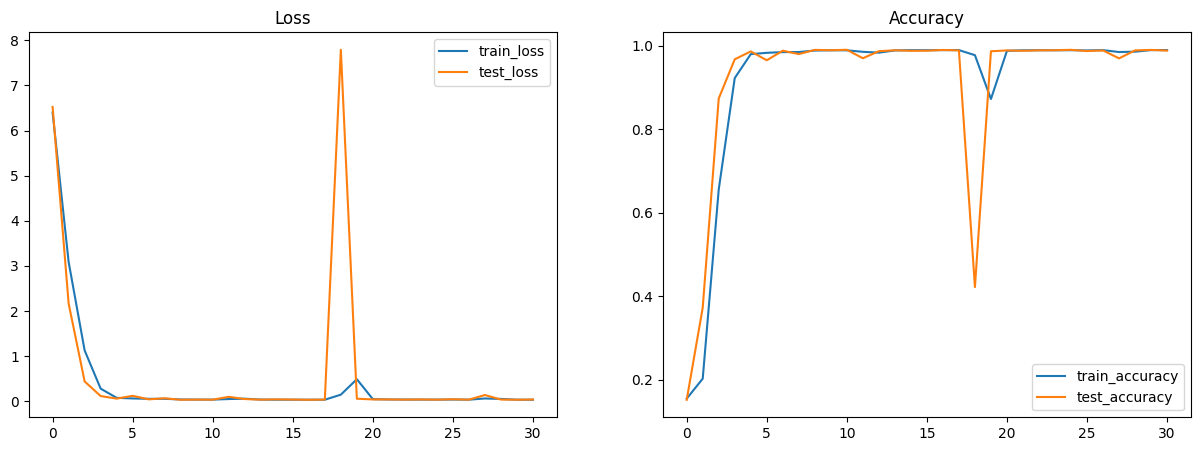

<Figure size 640x480 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [33]:

logits = fin_model.apply(fin_params, xb, training=False, mutable=['other_variables'])[0]
loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=yb).mean()

print(loss)

4.7566986


In [34]:
# def generate_text(idx, max_new_tokens, params):
# # idx is (B, T) array of indices in the current context
#     for i in range(max_new_tokens):
#         # crop idx to the last block_size tokens
#         idx_cond = idx[:, -block_size:]
#         # get the predictions
#         logits = fin_model.apply(params, idx_cond)
#         # focus only on the last time step
#         logits = logits[:, -1, :] # becomes (B, C)

#         if i == 0:
#             rng, rng_subkey = jax.random.split(jax.random.PRNGKey(12))
#         else:
#             rng, rng_subkey = jax.random.split(rng)

#         idx_next = jax.random.categorical(rng_subkey, logits, axis=-1, shape=(1, 1)) # (B, 1)


#         # append sampled index to the running sequence
#         idx = jnp.concatenate([idx, idx_next], axis=-1) # (B, T+1)

#     return idx

In [35]:
@partial(jax.jit, static_argnames=("self", "length"))
def generate_text(rng, params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = fin_model.apply(params, context, training=False, mutable=['other_variables'])[0]
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -1, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.zeros((1, block_size), dtype=jnp.int32)),
    (),
    length=length,
    )
    return new_tokens

/opt/conda/lib/python3.10/site-packages/jax/_src/api_util.py:231: SyntaxWarning: Jitted function has invalid argnames {'self'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [36]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, {'params': state.params}, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print(decode(token_gen))

[24, 33, 25, 31, 21, 33, 23, 10, 0, 19, 61, 53, 50, 52, 1, 52, 53, 42, 1, 57, 46, 53, 60, 43, 60, 43, 56, 43, 1, 41, 53, 56, 42, 1, 46, 39, 58, 58, 43, 56, 56, 43, 1, 39, 57, 1, 57, 39, 57, 43, 58, 1, 43, 56, 58, 1, 44, 53, 56, 57, 8, 0, 1, 56, 39, 41, 43, 1, 39, 56, 56, 53, 52, 50, 39, 51, 43, 1, 57, 53, 53, 46, 58, 1, 46, 53, 56, 41, 46, 41, 59, 58, 43, 1, 39, 52, 45, 56, 50, 43, 56, 53, 58, 53, 1, 47, 52, 45, 1, 40, 53, 51, 43, 1, 58, 53, 1, 58, 46, 43, 1, 61, 46, 52, 50, 1, 39, 59, 58, 1, 61, 43, 57, 1, 63, 53, 59, 57, 6, 0, 18, 53, 49, 1, 46, 39, 52, 42, 8, 0, 31, 19, 32, 26, 19, 10, 0, 16, 39, 59, 57, 43, 60, 39, 52, 45, 1, 46, 39, 50, 50, 47, 56, 58, 1, 46, 39, 42, 58, 43, 56, 52, 45, 43, 43, 42, 1, 40, 59, 58, 43, 57, 43, 1, 58, 46, 43, 53, 61, 1, 47, 52, 45, 1, 42, 59, 58, 1, 51, 39, 52, 1, 39, 58, 43, 42, 1, 45, 56, 53, 51, 39, 60, 43, 1, 58, 53, 43, 39, 56, 56, 43, 1, 47, 52, 1, 46, 39, 50, 50, 1, 58, 53, 5, 57, 58, 1, 45, 53, 39, 42, 1, 53, 59, 1, 59, 52, 1, 59, 47, 56, 42,

In [37]:
sdgh  fs

SyntaxError: invalid syntax (3505454285.py, line 1)

In [ ]:
!pip install mamba-ssm

In [ ]:
ones = lambda *size: torch.ones(*size).float().cuda()
zeros = lambda *size: torch.zeros(*size).float().cuda()
arange = lambda n: torch.arange(n).float().cuda()
rand = lambda size: torch.rand(*size).abs().float().cuda()

def create_torch(S = 128, Ba = 2, D = 4, N = 4):
    x = rand((Ba, 1, D, S))
    a = -ones((Ba, N, D, 1))
    b = ones((Ba, N, 1, S)) * 0.1
    c = rand((Ba, N, 1, S)) * 0.1
    delta = rand((Ba, 1, D, S)) * 0.1
    return x, a, b, c, delta

In [ ]:
import selective_scan_cuda

xx, aa, bb, cc, ddelta = create_torch()
y_from_repo = selective_scan_cuda.fwd(xx.squeeze(1), ddelta.squeeze(1), aa[0].squeeze(-1).T, bb.squeeze(-2)[:, None, :, :], cc.squeeze(-2)[:, None, :, :], None, None, None, False)
y_from_repo

In [ ]:
def discretize(a, b, delta):
    da = delta * a
    a_ = jnp.exp(da)
    b_ = b * delta
    return a_, b_

def ssm(x, a, b, c, delta):
    "Jax Implementation"
    y = []
    h = 0
    a_, b_ = discretize(a, b, delta)
    for k in range(x.shape[-1]):
        h = a_[..., k] * h + b_[..., k] * x[..., k]
        y.append((c[..., k] * h).sum(1, keepdims=True))
    return h, jnp.stack(y, -1)


In [ ]:
_, y_ = ssm(xx.cpu().numpy(), aa.cpu().numpy(), bb.cpu().numpy(), cc.cpu().numpy(), ddelta.cpu().numpy())

In [ ]:
from mamba_ssm import Mamba as Mamba_T
torch_mamba = Mamba_T(
      # This module uses roughly 3 * expand * d_model^2 parameters
      d_model=n_embd, # Model dimension d_model
      d_state=16,  # SSM state expansion factor
      d_conv=4,    # Local convolution width
      expand=2,    # Block expansion factor
)

In [ ]:
xm = x = rand((1, 1, n_embd, 32))
xm.shape

In [ ]:
torch_mamba(xm.squeeze(1))

In [ ]:
torch_mamba.in_proj

In [ ]:
y_mamba_repo = mamba_inner_fn()

In [ ]:
xm.squeeze(1).shape